In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

import torchvision 
import torchvision.transforms as transforms


import matplotlib.pyplot as plt 
import numpy as np 

# NN

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

#read the data for the NN
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(train_dataloader)

In [ ]:
class NNetwork(nn.Module):
    def __init__(self):
        super(NNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# if we want to utilize the GPU (if available), we need to assign the model to the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NNetwork().to(device)

# print the model structure
print(model)

NNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
print("Model structure: ", model, "\n\n")

for name, param in model2.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} \n")
    

Model structure:  NNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([256, 3072]) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([256]) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([256, 256]) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([256]) 

Layer: linear_relu_stack.4.weight | Size: torch.Size([256, 256]) 

Layer: linear_relu_stack.4.bias | Size: torch.Size([256]) 

Layer: linear_relu_stack.6.weight | Size: torch.Size([256, 256]) 

Layer: linear_relu_stack.6.bias | Size: torch.Size([256]) 


In [ ]:
# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the hyperparameters of the optimization/training process
learning_rate = 0.01  #0.1 0.01 1e-3
num_epochs = 100
batch_size = 64
moment=0.7 #0.3 0.7
# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=moment)

In [2]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  loss_total = 0. 
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_it = loss.item()
        loss_total += loss_it
        # per 100 batches report the value of the loss function on the training set
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  loss_total /= size          
  return loss_total


# the test loop does not need the optimizer
# we just pass the data through the trained model and measure the error in predictions
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct,test_loss

In [ ]:
acc_test_ls=[]
loss_test_ls=[]
loss_train_ls=[]
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train_ls.append(train_loop(train_dataloader, model, loss_fn, optimizer))
    acc, loss=test_loop(test_dataloader, model, loss_fn)
    acc_test_ls.append(acc)
    loss_test_ls.append(loss)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 26.5%, Avg loss: 0.030728 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 29.5%, Avg loss: 0.030361 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 39.1%, Avg loss: 0.026508 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 41.4%, Avg loss: 0.025335 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 0.024719 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 42.1%, Avg loss: 0.025496 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 45.3%, Avg loss: 0.023936 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 45.7%, Avg loss: 0.024031 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 47.2%, Avg loss: 0.023356 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.021804 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 50.3%, Avg los

In [ ]:
#Rebuild the model to run for the test set
# acc_train_ls=[]
# loss_train_ls=[]
# for t in range(num_epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_dataloader, model, loss_fn, optimizer)
#     acc, loss=test_loop(train_dataloader, model, loss_fn)
#     acc_train_ls.append(acc)
#     loss_train_ls.append(loss)
# print("Done!")

In [ ]:
while True:pass

KeyboardInterrupt: ignored

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


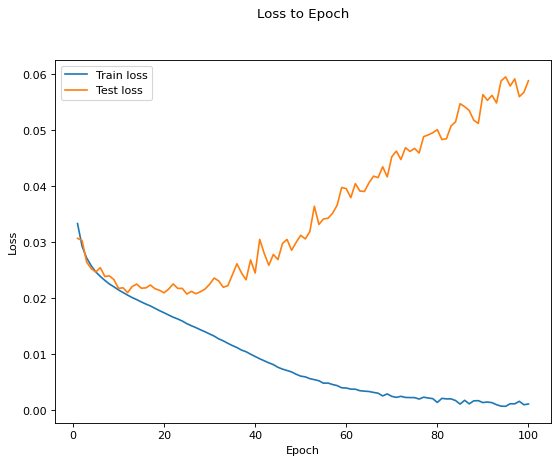

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


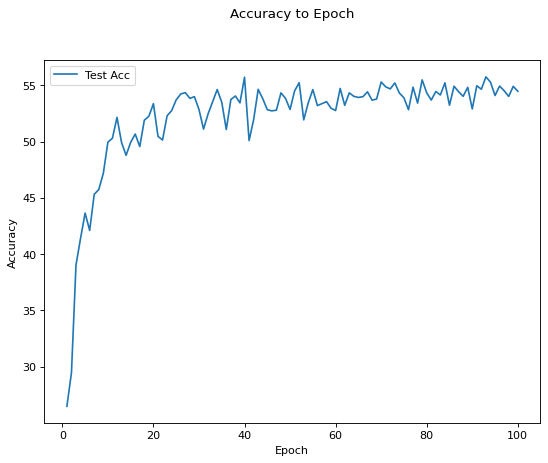

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

epoch=list(range(1,num_epochs+1))

# plot lines
plt.plot(epoch, loss_train_ls, label = "Train loss")
plt.plot(epoch, loss_test_ls, label = "Test loss")
plt.legend()
plt.title('Loss to Epoch', y=1.1)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('Loss_to_Epoch.eps', dpi = 300)
plt.show()


figure(figsize=(8, 6), dpi=80)

epoch=list(range(1,num_epochs+1))

# plot lines
# plt.plot(epoch, acc_train_ls, label = "Train Acc")
plt.plot(epoch, acc_test_ls, label = "Test Acc")
plt.legend()
plt.title('Accuracy to Epoch', y=1.1)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('Accuracy_to_Epoch.eps', dpi = 300)
plt.show()

# CNN

In [3]:
#Read CNN data and we need to normalize it first
BATCH_SIZE = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

CLASS_NAMES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class LeNet(nn.Module):
     def __init__(self):
         super().__init__()
         self.cnn_model = nn.Sequential(
             nn.Conv2d(3, 6, kernel_size = 5),  #(32x32x3)->(28x28x6)
             nn.ReLU(),
             nn.MaxPool2d(2, stride = 2),       #(30x30x6)->(14x14x6)
             nn.Conv2d(6, 16, kernel_size = 5), #(14x14x6)->(10x10x16)
             nn.ReLU(),
             nn.MaxPool2d(2, stride = 2))       #(10x10x16)->(5x5x16)
         self.fc_model = nn.Sequential(
             nn.Linear(5*5*16, 512), 
             nn.ReLU(),
             nn.Linear(512, 512),
             nn.ReLU(),
             nn.Linear(512, 10)) 

     def forward(self, x):     
         x = self.cnn_model(x)     
         x = x.view(x.size(0), -1)  
        #  print(x.shape)   
         x = self.fc_model(x)     
         return x





In [ ]:
print("Model structure: ", net, "\n\n")

for name, param in net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
    

In [ ]:
Cnn_acc_test=[]
Cnn_loss_test=[]
Cnn_loss_train=[]

# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
num_epochs = 70
learning_rate = [1e-3 ,0.01, 0.1] #0.1 0.01 1e-3
moment=0.3 #0.3 0.7

for lr in learning_rate:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  net = LeNet().to(device)
  print("################# LR= ",lr," #################")
  optimizer = torch.optim.SGD(net.parameters(), lr = lr)
  ls_acc_test=[]
  ls_loss_test=[]
  ls_loss_train=[]
  for t in range(num_epochs):
      print(f"Epoch {t+1}\n-------------------------------")

      ls_loss_train.append(train_loop(train_loader, net, loss_fn, optimizer))
      acc,loss=test_loop(test_loader, net, loss_fn)
      ls_acc_test.append(acc)
      ls_loss_test.append(loss)
  Cnn_acc_test.append(ls_acc_test)
  Cnn_loss_test.append(ls_loss_test)
  Cnn_loss_train.append(ls_loss_train)

  print("Done!")

################# LR=  0.001  #################
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.6%, Avg loss: 0.036148 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.1%, Avg loss: 0.036133 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 12.4%, Avg loss: 0.036114 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 14.3%, Avg loss: 0.036091 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 16.4%, Avg loss: 0.036059 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 17.5%, Avg loss: 0.036012 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 18.0%, Avg loss: 0.035940 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 18.4%, Avg loss: 0.035823 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 20.2%, Avg loss: 0.035624 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 21.9%, Avg loss: 0.035259 

Epoch 11
----------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


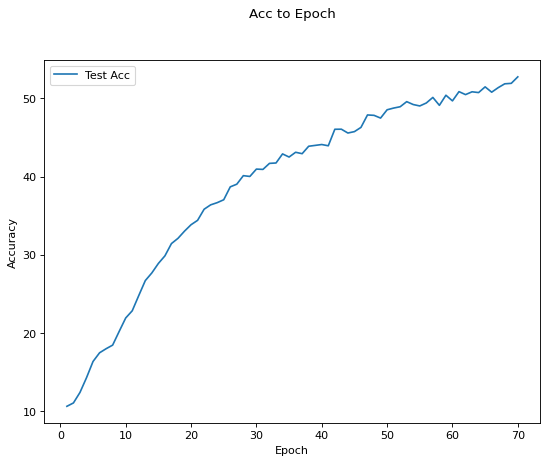

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


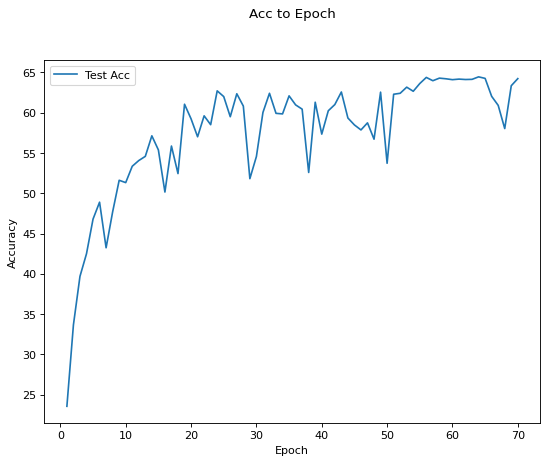

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


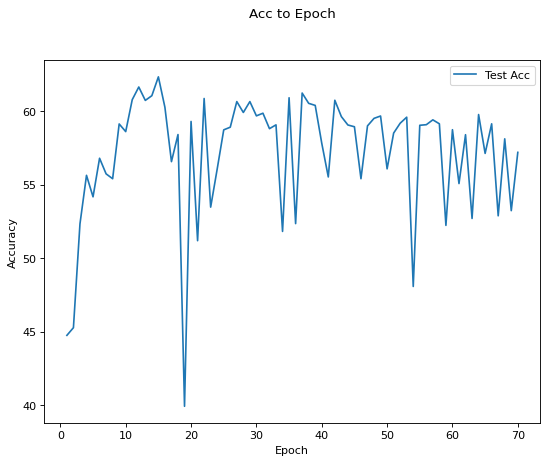

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


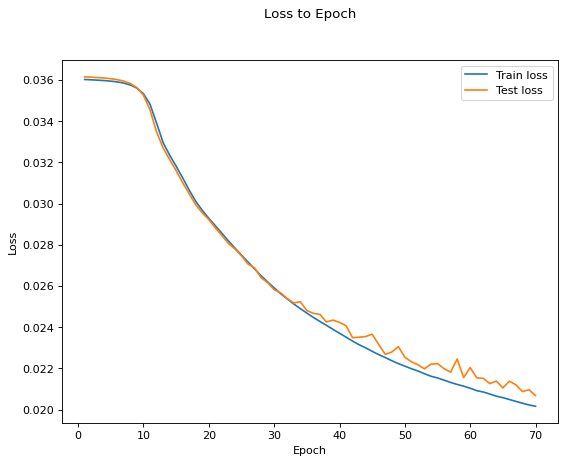

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


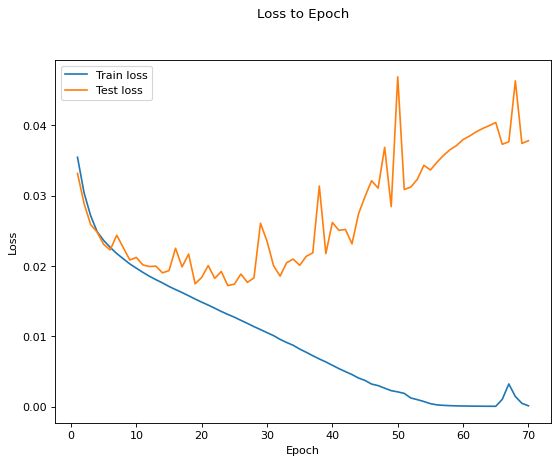

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


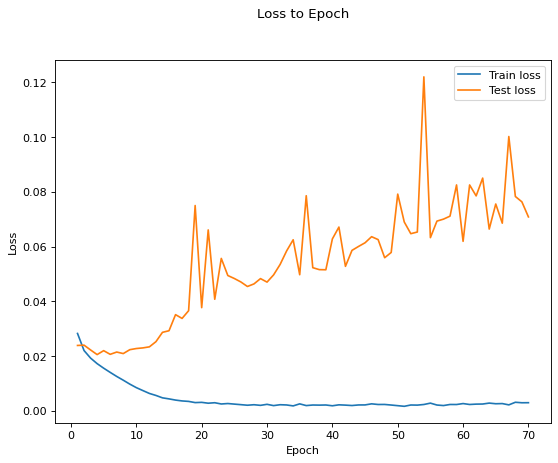

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

for i in range(len(Cnn_acc_test)):
  figure(figsize=(8, 6), dpi=80)

  epoch=list(range(1,num_epochs+1))

  # plot lines
  # plt.plot(epoch, Cnn_acc_train, label = "Train Acc")
  plt.plot(epoch, Cnn_acc_test[i], label = "Test Acc")
  plt.legend()
  plt.title('Acc to Epoch', y=1.1)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.savefig('CNN Accuracy_to_Epoch'+str(learning_rate[i])+'.eps', dpi = 300)
  plt.show()

for i in range(len(Cnn_loss_train)):
  figure(figsize=(8, 6), dpi=80)

  epoch=list(range(1,num_epochs+1))

  # plot lines
  plt.plot(epoch, Cnn_loss_train[i], label = "Train loss")
  plt.plot(epoch, Cnn_loss_test[i], label = "Test loss")
  plt.legend()
  plt.title('Loss to Epoch', y=1.1)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.savefig('CNN Loss_to_Epoch'+str(learning_rate[i])+'.eps', dpi = 300)
  plt.show()

# 2.3 NN

In [ ]:
#read the data for the NN
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#NN-150 definition
class NNetwork2(nn.Module):
    def __init__(self):
        super(NNetwork2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 150),
            nn.ReLU(),
            nn.Linear(150, 150),
            nn.ReLU(),
            nn.Linear(150, 150),
            nn.ReLU(),
            nn.Linear(150, 150),
            nn.ReLU(),
            nn.Linear(150, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# if we want to utilize the GPU (if available), we need to assign the model to the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2 = NNetwork2().to(device)

# print the model structure
print(model2)

NNetwork2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=150, bias=True)
    (1): ReLU()
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU()
    (4): Linear(in_features=150, out_features=150, bias=True)
    (5): ReLU()
    (6): Linear(in_features=150, out_features=150, bias=True)
    (7): ReLU()
    (8): Linear(in_features=150, out_features=10, bias=True)
  )
)


In [ ]:
#used for the Comparison Between NN and CNN
total_p=0
for name, param in model2.named_parameters():
    nn1=1
    print(f"Layer: {name} | Size: {param.size()} \n")
    for s in list(param.size()):
            nn1 = nn1*s
    total_p += nn1
print("Total parameters: ",total_p)    

Layer: linear_relu_stack.0.weight | Size: torch.Size([150, 3072]) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([150]) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([150, 150]) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([150]) 

Layer: linear_relu_stack.4.weight | Size: torch.Size([150, 150]) 

Layer: linear_relu_stack.4.bias | Size: torch.Size([150]) 

Layer: linear_relu_stack.6.weight | Size: torch.Size([150, 150]) 

Layer: linear_relu_stack.6.bias | Size: torch.Size([150]) 

Layer: linear_relu_stack.8.weight | Size: torch.Size([10, 150]) 

Layer: linear_relu_stack.8.bias | Size: torch.Size([10]) 

Total parameters:  530410


In [ ]:
# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the hyperparameters of the optimization/training process
learning_rate =0.005  #0.1 0.01 1e-3
num_epochs = 50
batch_size = 64

# define the optimizer object
optimizer = torch.optim.SGD(model2.parameters(), lr = learning_rate, momentum=0.9) #momentum=0.9

In [ ]:
acc_test_ls=[]
loss_test_ls=[]
loss_train_ls=[]
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train_ls.append(train_loop(train_dataloader, model2, loss_fn, optimizer))
    acc, loss=test_loop(test_dataloader, model2, loss_fn)
    acc_test_ls.append(acc)
    loss_test_ls.append(loss)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 30.3%, Avg loss: 0.029965 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 36.7%, Avg loss: 0.027546 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 41.9%, Avg loss: 0.025401 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 42.4%, Avg loss: 0.025037 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 43.9%, Avg loss: 0.024119 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 44.7%, Avg loss: 0.024316 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 47.8%, Avg loss: 0.023094 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 47.0%, Avg loss: 0.022841 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 48.4%, Avg loss: 0.022571 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 48.6%, Avg loss: 0.022395 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 48.8%, Avg los

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


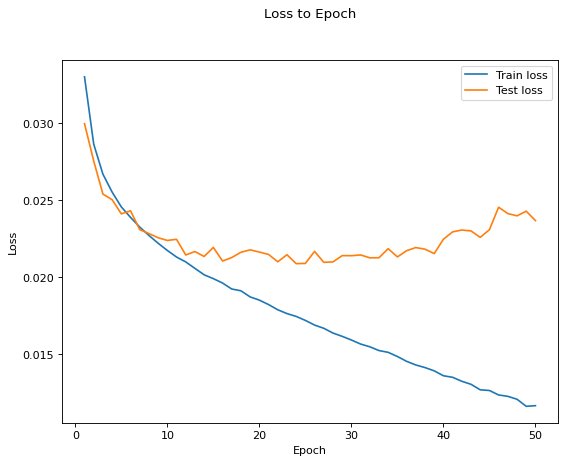

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


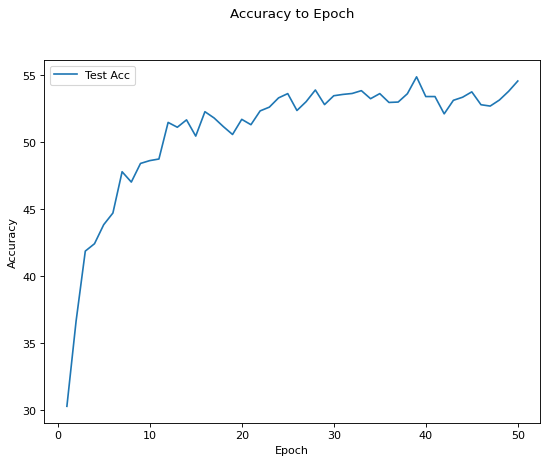

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

epoch=list(range(1,num_epochs+1))

# plot lines
plt.plot(epoch, loss_train_ls, label = "Train loss")
plt.plot(epoch, loss_test_ls, label = "Test loss")
plt.legend()
plt.title('Loss to Epoch', y=1.1)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('Loss_to_Epoch.eps', dpi = 300)
plt.show()


figure(figsize=(8, 6), dpi=80)

epoch=list(range(1,num_epochs+1))

# plot lines
# plt.plot(epoch, acc_train_ls, label = "Train Acc")
plt.plot(epoch, acc_test_ls, label = "Test Acc")
plt.legend()
plt.title('Accuracy to Epoch', y=1.1)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('Accuracy_to_Epoch.eps', dpi = 300)
plt.show()

In [ ]:
print(max(acc_test_ls))

54.879999999999995


# 2.3 CNN

In [ ]:
#Read CNN data and we need to normalize it first
BATCH_SIZE = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

CLASS_NAMES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
#CNN2 definition
class LeNet2(nn.Module):
     def __init__(self):
         super().__init__()
         self.cnn_model = nn.Sequential(
             nn.Conv2d(3, 32, kernel_size = 5),  #(32x32x3)->(28x28x32)
             nn.ReLU(),
             nn.MaxPool2d(2, stride = 2),     #(28x28x32)->(14x14x32)
             nn.Conv2d(32, 64, kernel_size = 5), #(14x14x32)->(10x10x64)
             nn.ReLU(),
             nn.MaxPool2d(2, stride = 2))       #(10x10x64)->(5x5x64)
         self.fc_model = nn.Sequential(
             nn.Linear(5*5*64, 256), 
             nn.ReLU(),
             nn.Linear(256, 256),
             nn.ReLU(),
             nn.Linear(256, 10)) 

     def forward(self, x):     
         x = self.cnn_model(x)     
         x = x.view(x.size(0), -1)  
        #  print(x.shape)   
         x = self.fc_model(x)     
         return x



In [5]:
#used for the Comparison Between NN and CNN2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LeNet2().to(device)
print("Model structure: ", model, "\n\n")

total_p=0
for name, param in model.named_parameters():
    nn1=1
    print(f"Layer: {name} | Size: {param.size()} \n")
    for s in list(param.size()):
            nn1 = nn1*s
    total_p += nn1
print("Total parameters: ",total_p)    

Model structure:  LeNet2(
  (cnn_model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=1600, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) 


Layer: cnn_model.0.weight | Size: torch.Size([32, 3, 5, 5]) 

Layer: cnn_model.0.bias | Size: torch.Size([32]) 

Layer: cnn_model.3.weight | Size: torch.Size([64, 32, 5, 5]) 

Layer: cnn_model.3.bias | Size: torch.Size([64]) 

Layer: fc_model.0.weight | Size: torch.Size([256, 1600]) 

Layer: fc_model.0.bias | Size: torch.Size([256]) 

Layer: fc_model.2.weight | Size: tor

In [6]:
Cnn_acc_test=[]
Cnn_loss_test=[]
Cnn_loss_train=[]

# define the corresponding loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50
learning_rate = [0.005] #0.1 0.01 1e-3
moment=0.9 #0.3 0.7

for lr in learning_rate:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  net = LeNet2().to(device)
  print("################# LR= ",lr," #################")
  optimizer = torch.optim.SGD(net.parameters(), lr = lr)
  ls_acc_test=[]
  ls_loss_test=[]
  ls_loss_train=[]
  for t in range(num_epochs):
      print(f"Epoch {t+1}\n-------------------------------")

      ls_loss_train.append(train_loop(train_loader, net, loss_fn, optimizer))
      acc,loss=test_loop(test_loader, net, loss_fn)
      ls_acc_test.append(acc)
      ls_loss_test.append(loss)
  Cnn_acc_test.append(ls_acc_test)
  Cnn_loss_test.append(ls_loss_test)
  Cnn_loss_train.append(ls_loss_train)

  print("Done!")

################# LR=  0.005  #################
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 21.4%, Avg loss: 0.035896 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 24.9%, Avg loss: 0.032940 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 31.4%, Avg loss: 0.029920 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 35.3%, Avg loss: 0.027759 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 39.8%, Avg loss: 0.025951 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 41.2%, Avg loss: 0.025129 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 45.1%, Avg loss: 0.023623 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 47.0%, Avg loss: 0.023160 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 48.8%, Avg loss: 0.022615 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.021657 

Epoch 11
----------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


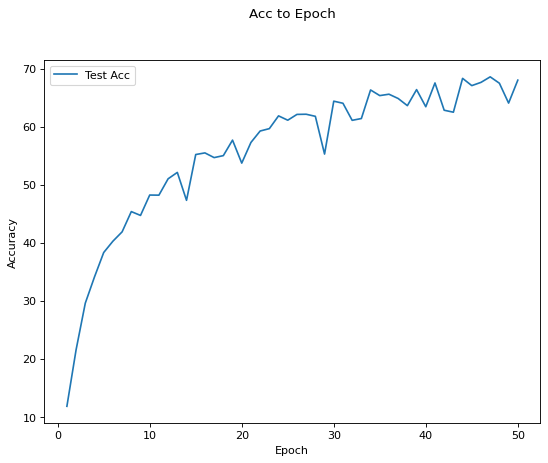

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


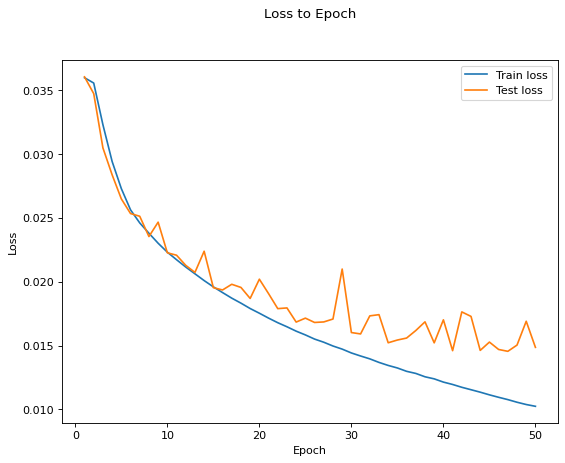

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

for i in range(len(Cnn_acc_test)):
  figure(figsize=(8, 6), dpi=80)

  epoch=list(range(1,num_epochs+1))

  # plot lines
  # plt.plot(epoch, Cnn_acc_train, label = "Train Acc")
  plt.plot(epoch, Cnn_acc_test[i], label = "Test Acc")
  plt.legend()
  plt.title('Acc to Epoch', y=1.1)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.savefig('CNN Accuracy_to_Epoch'+str(learning_rate[i])+'.eps', dpi = 300)
  plt.show()

for i in range(len(Cnn_loss_train)):
  figure(figsize=(8, 6), dpi=80)

  epoch=list(range(1,num_epochs+1))

  # plot lines
  plt.plot(epoch, Cnn_loss_train[i], label = "Train loss")
  plt.plot(epoch, Cnn_loss_test[i], label = "Test loss")
  plt.legend()
  plt.title('Loss to Epoch', y=1.1)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.savefig('CNN Loss_to_Epoch'+str(learning_rate[i])+'.eps', dpi = 300)
  plt.show()

In [ ]:
print(max(max(Cnn_acc_test)))

68.58999999999999


# 2.4

frog


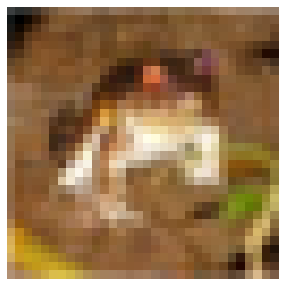

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
 
from torch.utils.data import  DataLoader
from torchvision import models
 
import torchvision.transforms as transforms
import torchvision.datasets as dataset
 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

Χ=trainset[0]
# print(CLASS_NAMES[Y[0]])
#Visualizing CIFAR 10
fig, axes1 = plt.subplots(figsize=(5,5))

axes1.set_axis_off()
axes1.imshow(X[0:0+1][0])


In [82]:
#img preprocessed
img=X[0]

img=np.array(img)
img=transform(img)
img=img.unsqueeze(0)
print(img.size())


torch.Size([1, 3, 32, 32])


In [83]:
#find the Conv2d layers we do no need that actually
no_of_layers=0
conv_layers=[]
 
model_children=list(net.children())
 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

2


In [84]:
#for the first layer take the outputs
results = [conv_layers[0](img.to(device))]
## Uncomment these lines to run it for both layers
# for i in range(1, len(conv_layers)):
#     results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


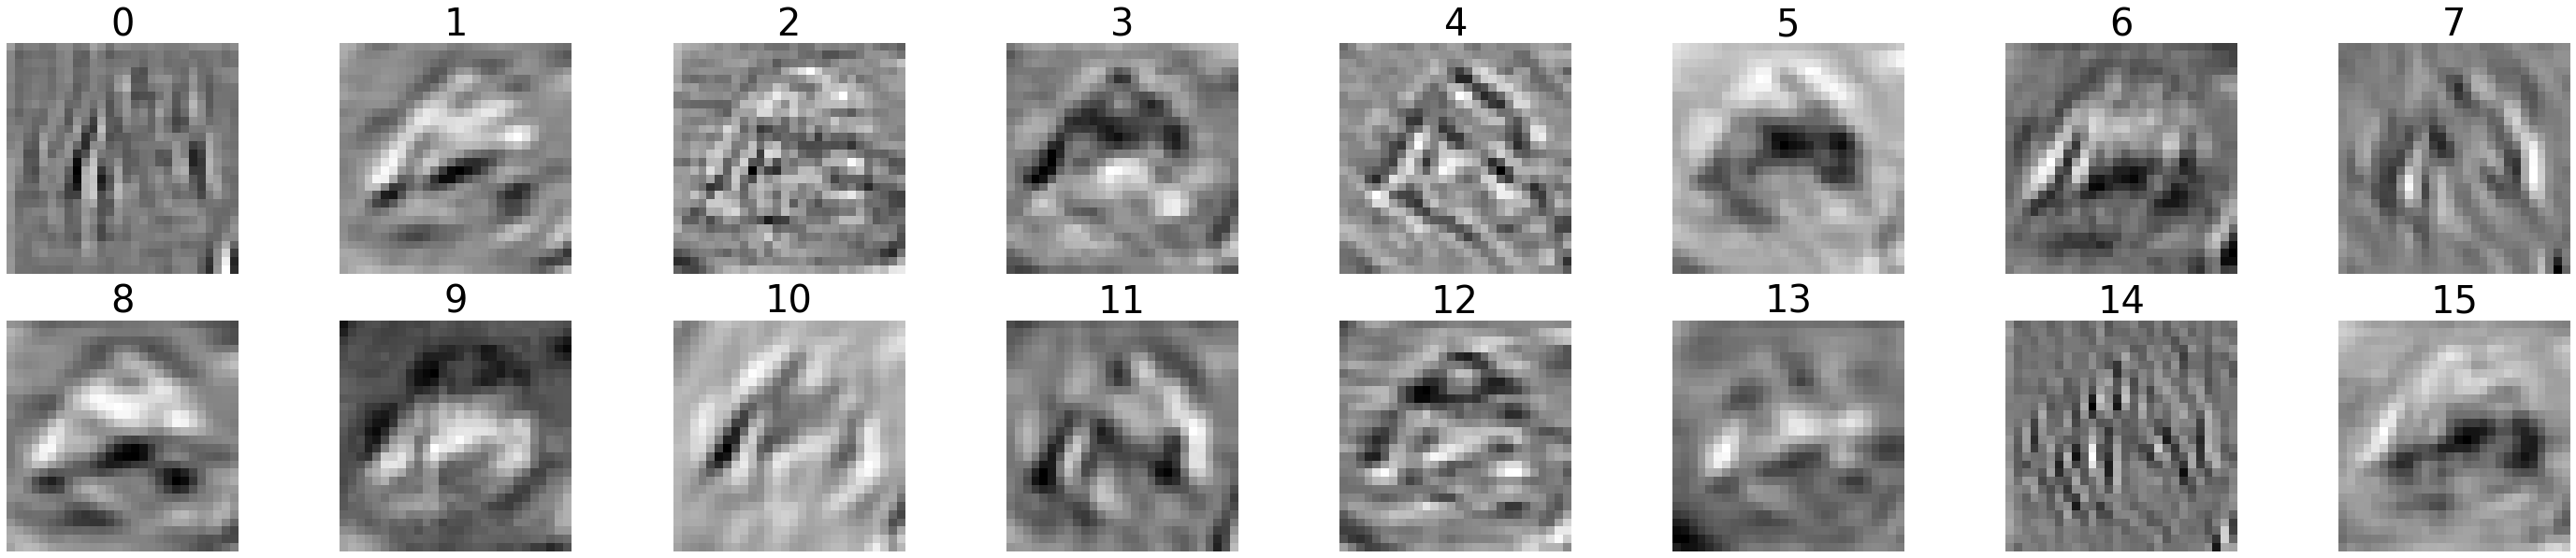

In [92]:
#plot the ouputs of the first layer (results of 16 filters)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
        plt.title(i,fontsize=40)
    plt.show()
    plt.close()